## Training the Stable Baselines agents using Protected RMSCA environment

In [1]:
import os
import gym
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Stable Baselines

In [2]:
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3, DDPG
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common import results_plotter

stable_baselines3.__version__

'1.8.0'

## Environment imports

In [3]:
# from optical_rl_gym.envs.rmcsa_env_dpp import RMCSADPPEnv
from optical_rl_gym.envs.rmcsa_env import SimpleMatrixObservation

## Define a callback function

In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
        How often we check for improved model (in number of steps)
    :param log_dir: (str)
        Path to the folder where the model will be saved.
        It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
        Verbosity level 0: not output 1: info 2: debug
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.worst_mean_reward = np.inf
        self.best_mean_bbr = -np.inf
        self.worst_mean_bbr = np.inf
        
    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f}\n \
                        Worst mean reward: {self.worst_mean_reward:.2f}\n \
                        Last mean reward: {mean_reward:.2f}"# \n \
                        # Best mean BBR: {self.best_mean_bbr:.2f}\n \
                        # Worst mean BBR: {self.worst_mean_bbr:.2f}\n \
                        # Last mean BBR: {bbr:.2f}"
                    )
                    
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    
                if mean_reward < self.worst_mean_reward:
                    self.worst_mean_reward = mean_reward
                    
                # if bbr > self.best_mean_bbr:
                #     self.best_mean_bbr = bbr
                    
                # if bbr < self.worst_mean_bbr:
                #     self.worst_mean_bbr = bbr
                
                if self.verbose > 0:
                    clear_output(wait=True)
                    
        return True

## Setting up the environment

The parameters are set as in the [this work](https://doi.org/10.1364/NETWORKS.2018.NeW3F.5).

In [5]:
topology_name = 'nsfnet_chen'
k_paths = 50
file_path = f'../topologies/{topology_name}_{k_paths}-paths_6-modulations.h5'

with open(file_path, 'rb') as f:
    topology = pickle.load(f)
    
monitor_info_keywords = ('episode_service_blocking_rate', 'episode_bit_rate_blocking_rate', 'episode_failure_slots', 'episode_failure_disjointness', 'episode_failure_crosstalk')

env_args = dict(
  topology=topology,
  episode_length=1000,
  load=400,
  # mean_service_holding_time=10800.0,
  num_spectrum_resources=320,
  num_spatial_resources=7,
  # modulation_formats={}, # some thing
  # worst_xt={}, # some thing
  # node_request_probabilities={}, # some thing
  # bit_rate_selection="continous",
  # bit_rates=[], # some thing
  # bit_rate_probabilities=[], # some thing
  # bit_rate_lower_bound=25,
  # bit_rate_higher_bound=100,
  seed=10,
  # allow_rejection=True,
  # reset=True,
  channel_width=12.5,
)

## Creating the monitors and agent

In [6]:
# Create log dir
log_dir = "tmp/rmcsadpp-dense-ppo/"
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, verbose=1)

env = gym.make('RMCSADPPDense-v0', **env_args)

# uses a matrix observation
env = SimpleMatrixObservation(env)

# logs will be saved in log_dir/monitor.csv
# in our case, on top of the usual monitored metrics, we also monitor service and bit rate blocking rates
env = Monitor(env, log_dir + 'training', info_keywords=monitor_info_keywords)
# for more information about the Monitor wrapper, please refer to the Stable Baselines documentation
# https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# here goes the arguments for the policy network to be used
# we are using a simple Multi Layer Perceptron (MLP) with 5 hidden layers with 128 neurons each
# we are using the default activation function (ReLU) and the default output activation function (None)
policy_args = dict(
  net_arch=[128] * 5 # 5 hidden layers with 128 neurons each
)

# create the agent
# we are using the Proximal Policy Optimization (PPO) algorithm with the Multi Layer Perceptron (MLP) policy network
# the agent will be trained for 10^6 steps
# we are using a discount factor of 0.95
# we are using a learning rate of 10^-6
agent = PPO(MlpPolicy, env, verbose=0, tensorboard_log="./tb/PPO-RMCSADPPDense-v0/", policy_kwargs=policy_args, gamma=0.95, learning_rate=10e-5, clip_range=0.2, n_epochs=10, batch_size=512)

## Training the agent

In [7]:
trained = agent.learn(total_timesteps=1000000, callback=callback)

Num timesteps: 1001000
Best mean reward: 253297.01
                         Worst mean reward: -10572.76
                         Last mean reward: 253362.25
Saving new best model to tmp/rmcsadpp-dense-ppo/best_model.zip


## Plotting the training progress

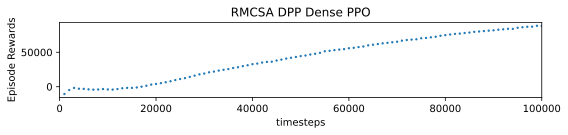

In [8]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "RMCSA DPP Dense PPO")

## Plotting results

In [9]:
training_data = pd.read_csv(log_dir + 'training.monitor.csv', skiprows=1)
training_data.describe()

,r,l,t,episode_service_blocking_rate,episode_bit_rate_blocking_rate,episode_failure_slots,episode_failure_disjointness,episode_failure_crosstalk
count,1001.000000,1001.0,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.0
mean,184532.541808,1000.0,2945.461615,0.891175,0.947346,102.353646,0.749291,0.0
std,64799.548789,0.0,1820.729688,0.031718,0.015169,37.431415,0.049400,0.0
min,-10572.759151,1000.0,3.126700,0.836000,0.920971,0.000000,0.667000,0.0
25%,148517.900095,1000.0,1363.073795,0.869000,0.936736,80.000000,0.714000,0.0
50%,204159.692471,1000.0,2705.535072,0.881000,0.942768,112.000000,0.736000,0.0
75%,236662.741739,1000.0,4633.222021,0.907000,0.955038,131.000000,0.774000,0.0
max,257164.885120,1000.0,6204.264585,0.999000,0.999214,181.000000,0.947000,0.0


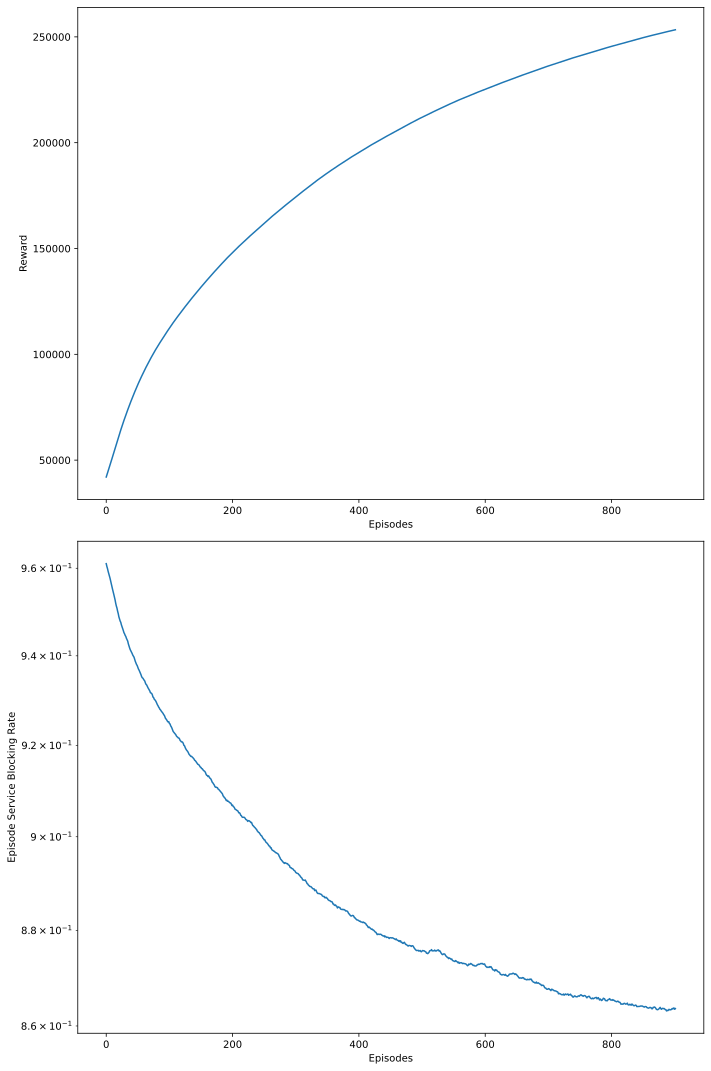

In [14]:
plotting_average_window = 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

ax1.plot(np.convolve(training_data['r'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'))

ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward')

ax2.semilogy(np.convolve(training_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'))

ax2.set_xlabel('Episodes')
ax2.set_ylabel('Episode Service Blocking Rate')

# ax3.semilogy(np.convolve(training_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'))

# ax3.set_xlabel('Episodes')
# ax3.set_ylabel('Episode Bit Rate Blocking Rate')

plt.tight_layout()
plt.show()